In [2]:
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import os
import pickle
import utils


In [3]:
with open('../result_log/FINALPREDS-1.pkl', 'rb') as f:
    data = pickle.load(f)

print(list(data.keys()))

def get_RFF_PINN_preds(data, key):
    result = data[key]
    seeds = list(result.keys())
    if len(seeds) <1:
        print('no seeds for key: ', key)
        return None
    best_seed = seeds[0]
    for seed in seeds:
        if result[seed]['finallerror'] < result[best_seed]['finallerror']:
            best_seed = seed
    return result[best_seed]['preds']

for key in list(data.keys()):
    preds = get_RFF_PINN_preds(data, key)



['d1poisson_dv11_2pi', 'd1poisson_dv36_2pi', 'd1poisson_dv37_2pi', 'd2poisson_dv1_2pi', 'd2poisson_dv3_2pi', 'd2allencahn_dv11_2pi', 'd1advection_dv38_2pi', 'd1poisson_dv11_1', 'd1poisson_dv36_1_5000', 'd1poisson_dv36_1_10000', 'd1poisson_dv37_1', 'd2allencahn_dv11_1']


In [36]:

equation_dict = {
    'poisson_1d-sin_cos':'u = sin(6x)cos(100x)',
    'poisson_1d-x2_add_sinx': 'u = sin(500x)-2*(x-0.5)^2',
    'poisson_1d-mix_sin':'u= sin(x) + 0.1*sin(20x) + 0.05*cos(100x)',
    'poisson_1d-x_time_sinx': 'u = x*sin(200x)',
    }


def load_and_predict(prefix, save_name,new_test=False, N_col=200, x_scale=1.0):    

    with open(prefix + save_name + '.pkl', 'rb') as f:
        params, log_dict, trick_paras = pickle.load(f)

    if 'N_col' not in list(trick_paras.keys()):
        trick_paras['N_col'] = N_col

    if 'x_scale' not in list(trick_paras.keys()):
        trick_paras['x_scale'] = x_scale

    model, preds, Xtr = utils.get_model_1d(params, trick_paras,new_test)

    return model, preds, Xtr, log_dict

def load_and_predict_extra(prefix, save_name,new_test=False,N_col=200, x_scale=1.0,):    

    with open(prefix + save_name + '.pkl', 'rb') as f:
        params, params_extra, log_dict, trick_paras = pickle.load(f)

    if 'N_col' not in list(trick_paras.keys()):
        trick_paras['N_col'] = N_col

    if 'x_scale' not in list(trick_paras.keys()):
        trick_paras['x_scale'] = x_scale

    model, preds, Xtr = utils.get_model_1d_extra(params, params_extra, trick_paras,new_test)

    return model, preds, Xtr, log_dict


def draw_fig(model, preds, Xtr, log_dict,legend=True, x_tick_label = None, y_ticks_label = None):

    err = min(log_dict['err_list'])
    equation_name =model.trick_paras['equation']
    kernel_name = model.cov_func.__class__.__name__

    # generate new figure
    plt.figure(figsize=(8, 6))

    plt.plot(model.Xte.flatten(), model.yte.flatten(), 'k-', label='Ground Truth')
    plt.plot(model.Xte.flatten(), preds.flatten(), 'r-', label='Prediction')
    plt.scatter(Xtr.flatten(), model.y.flatten(), c='g', label='Boundary', s=150, )

    if legend:

        plt.legend(loc=2, fontsize=20)
        plt.ylabel('u(x)',fontsize=20)

    # se x, y label, set font size
    plt.xlabel('x', fontsize=20)

    # set x, y tick size as text
    plt.xticks(x_tick_label[0],x_tick_label[1],fontsize=20)
    plt.yticks(y_ticks_label[0],y_ticks_label[1],fontsize=20)




    # print eq name, kernel_name and err as title
    # plt.title('Equation: {}, \n Kernel: {},   L2 Err: {:.2e}'.format(equation_dict[equation_name], kernel_name, err))

    # to save figure
    prefix = '../figs/' + equation_name + '/'

    # create folder if not exist
    if not os.path.exists(prefix):
        os.makedirs(prefix)

    # save as pdf and png
    plt.savefig(prefix + kernel_name + '.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(prefix +kernel_name+ '.png', dpi=300, bbox_inches='tight')

def draw_RFF_PINN(u,data,key,x_scale,save_name, legend=True, x_tick_label = None, y_ticks_label = None, downsampling=10):
    preds = get_RFF_PINN_preds(data, key).squeeze()
    n_col = preds.size
    X_te = np.linspace(0,x_scale,n_col)

    X_te = X_te[::downsampling]
    preds = preds[::downsampling]

    # X_te_truth = np.linspace(0,x_scale,300)

    X_te_truth = np.linspace(0,x_scale,len(X_te))

    truth = u(X_te_truth)

    print('truth shape: ', len(X_te))

    # generate new figure
    plt.figure(figsize=(8, 6))

    plt.plot(X_te_truth, truth, 'k-', label='Ground Truth')
    plt.plot(X_te, preds,'r-', label='Prediction')
    plt.scatter([X_te[0],X_te[-1]], [truth[0],truth[-1]   ], c='g', label='Boundary', s=150, )

    plt.xlabel('x', fontsize=20)

    if legend:

        plt.legend(loc=2, fontsize=20)
        plt.ylabel('u(x)',fontsize=20)

    # set x, y tick size as text
    plt.xticks(x_tick_label[0],x_tick_label[1],fontsize=20)
    plt.yticks(y_ticks_label[0],y_ticks_label[1],fontsize=20)

    # save as pdf and png
    plt.savefig(save_name + '.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(save_name+ '.png', dpi=300, bbox_inches='tight')


truth shape:  500


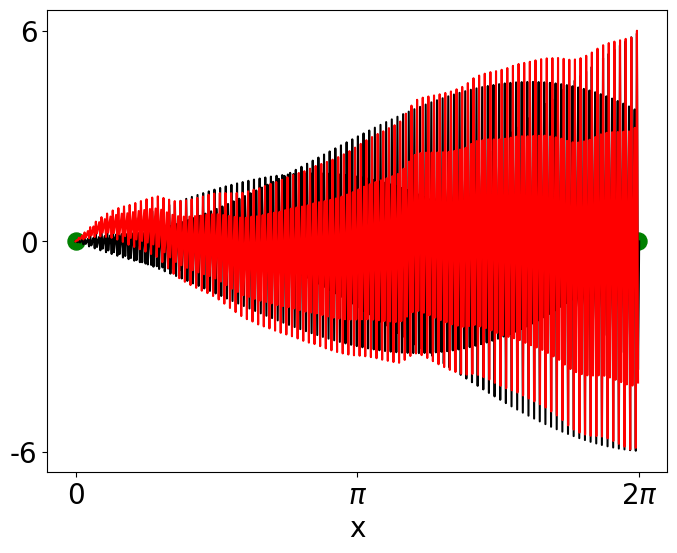

In [16]:
# for poisson_x_time_sinx
u = lambda x: x*np.sin(200*x)
x_scale = 2*np.pi
key = 'd1poisson_dv37_2pi'

x_tick_label =[[0, np.pi,2*np.pi],['0','$\pi$','$2\pi$']]
y_ticks_label = [[-6,0,6],['-6','0','6']]

save_name = '../figs/poisson_1d-x_time_sinx/RFF_PINN'

draw_RFF_PINN(u,data,key,x_scale,save_name,False, x_tick_label , y_ticks_label,40)

equation is:  poisson_1d-x_time_sinx
kernel is: Matern52_Cos_1d
equation is:  poisson_1d-x_time_sinx
kernel is: Matern52_1d
equation is:  poisson_1d-x_time_sinx
kernel is: SE_1d
equation is:  poisson_1d-x_time_sinx
kernel is: SE_Cos_1d


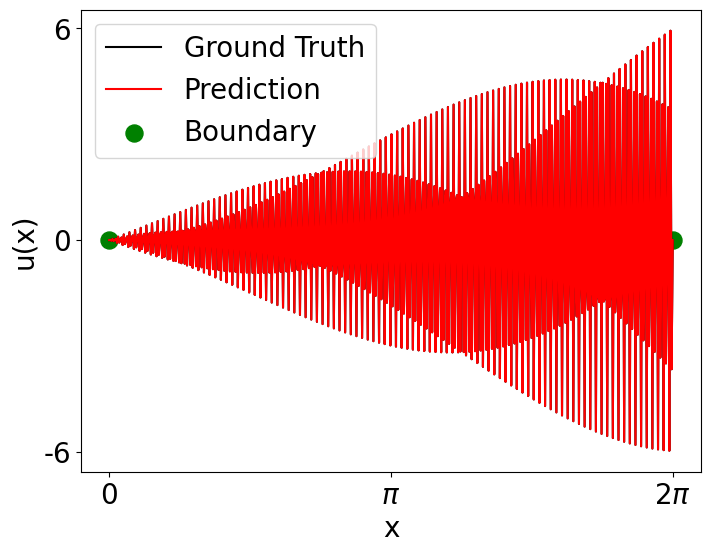

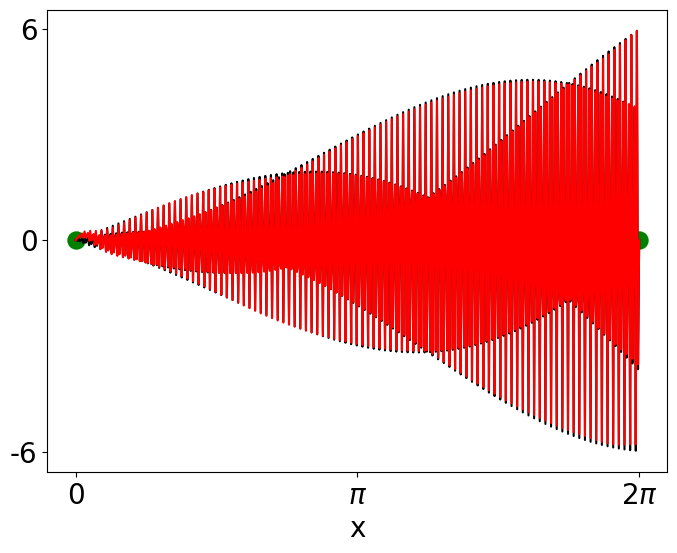

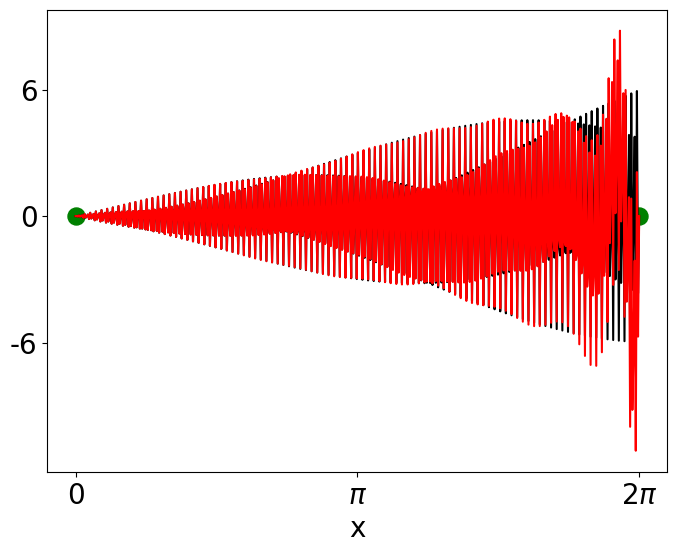

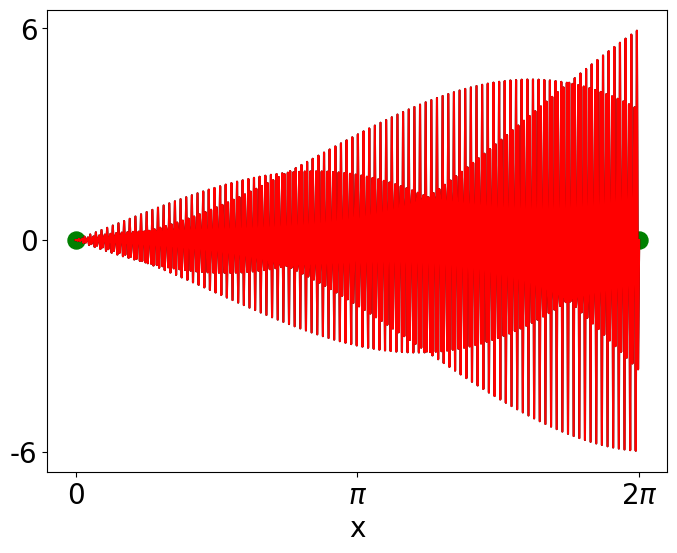

In [14]:
# for poisson_x_time_sinx

kernel_list = ['Matern52_Cos_1d','Matern52_1d','SE_1d','SE_Cos_1d']

# prefix = '../result_log/poisson_1d-sin_cos/kernel_Matern52_Cos_1d/epoch_1000000/Q30/'
save_name = 'llk_weight-200.0-nu-1-Q-30-epoch-100000-lr-0.0100-freqscale=50-logdet-1-x-2pi-Ncol-900'

x_tick_label =[[0, np.pi,2*np.pi],['0','$\pi$','$2\pi$']]
y_ticks_label = [[-6,0,6],['-6','0','6']]

for i, kernel_name in enumerate(kernel_list):
    prefix = '../result_log/poisson_1d-x_time_sinx/kernel_%s/epoch_100000/Q30/'%(kernel_name)
    legend = True if i==0 else False
    model, preds, Xtr, log_dict = load_and_predict(prefix, save_name, 500)
    draw_fig(model, preds, Xtr, log_dict,legend, x_tick_label, y_ticks_label)

# draw RFF PINN

truth shape:  500


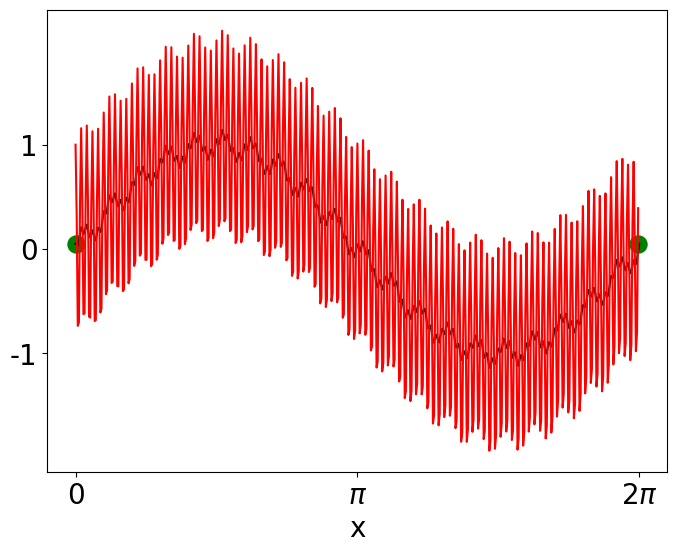

In [41]:
# for poisson_1d-mix_sin
u1 = lambda x: np.sin(x) + 0.1*np.sin(20*x) + np.cos(100*x)
u = lambda x: np.sin(x) + 0.1*np.sin(20*x) + 0.05*np.cos(100*x)

x_scale = 2*np.pi
key = 'd1poisson_dv11_2pi'

x_tick_label =[[0, np.pi,2*np.pi],['0','$\pi$','$2\pi$']]
y_ticks_label = [[-1,0,1],['-1','0','1']]

save_name = '../figs/poisson_1d-mix_sin/RFF_PINN'

draw_RFF_PINN(u,data,key,x_scale,save_name,False, x_tick_label , y_ticks_label,10)


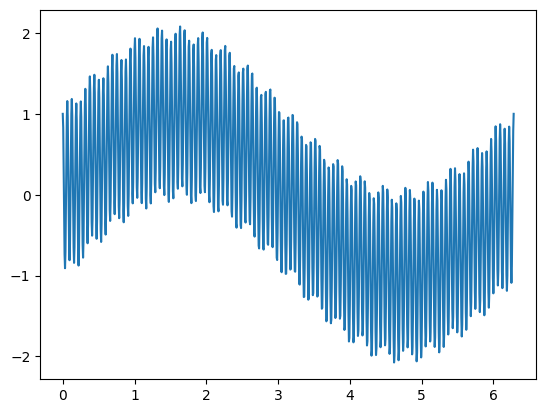

In [40]:
xte = np.linspace(0,2*np.pi,1000)
y = u1(xte)
plt.plot(xte,y)


equation is:  poisson_1d-mix_sin
kernel is: SE_1d
equation is:  poisson_1d-mix_sin
kernel is: Matern52_1d
equation is:  poisson_1d-mix_sin
kernel is: Matern52_Cos_1d
using extra GP with kernel: Matern52_1d
equation is:  poisson_1d-mix_sin
kernel is: SE_Cos_1d
using extra GP with kernel: Matern52_1d


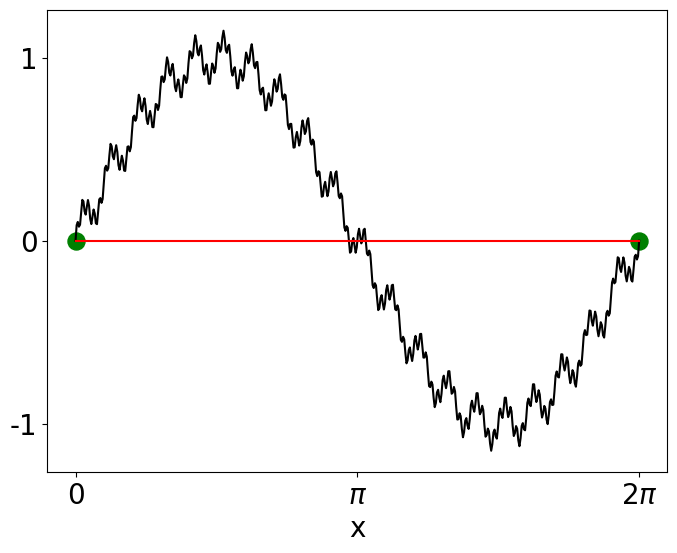

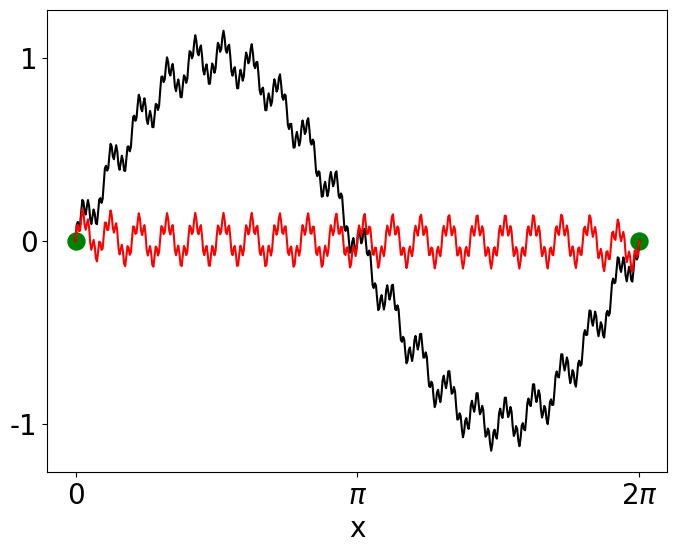

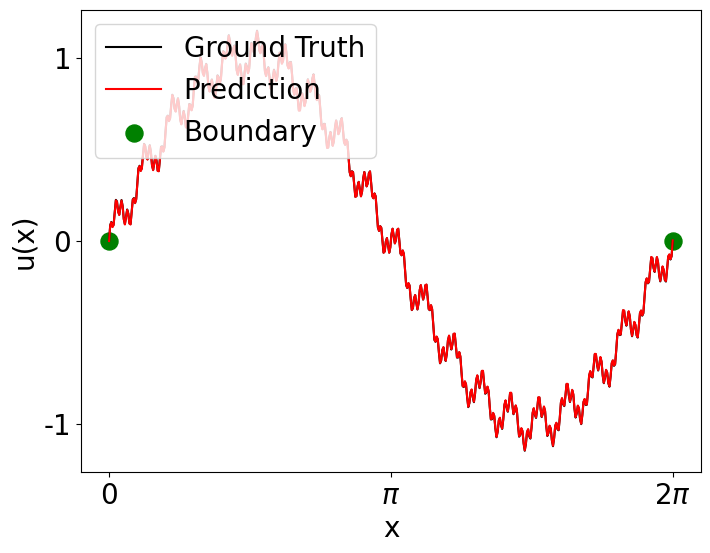

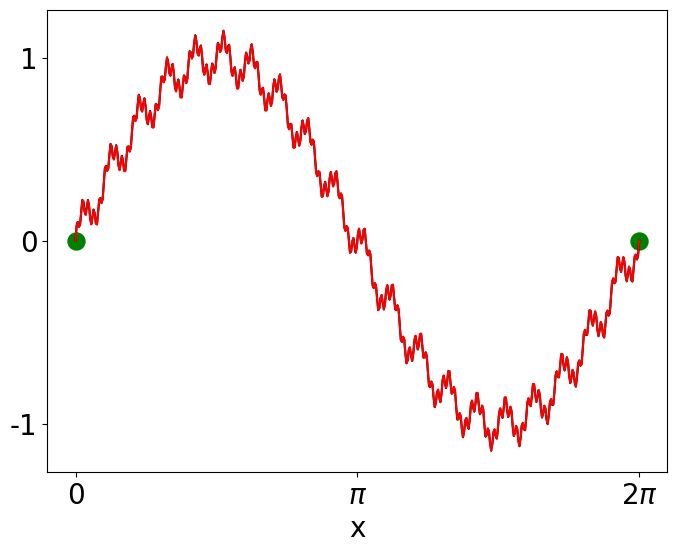

In [29]:
# for poisson_1d-mix-sin

x_tick_label =[[0, np.pi,2*np.pi],['0','$\pi$','$2\pi$']]
y_ticks_label = [[-1,0,1],['-1','0','1']]

new_test = 500

for kernel_name in ['SE_1d','Matern52_1d']:
    prefix = '../result_log/poisson_1d-mix_sin/kernel_%s/epoch_100000/Q30/'%(kernel_name)
    save_name = 'llk_weight-200.0-nu-1-Q-30-epoch-100000-lr-0.0100-freqscale=30-logdet-1-x-2pi-Ncol-900'

    model, preds, Xtr, log_dict = load_and_predict(prefix, save_name,new_test )
    draw_fig(model, preds, Xtr, log_dict,False, x_tick_label, y_ticks_label)


kernel_name = 'Matern52_Cos_1d-extra-Matern52_1d'
prefix = '../result_log/poisson_1d-mix_sin/kernel_%s/epoch_50000/Q30/'%(kernel_name)
save_name = 'llk_weight-200.0-nu-1-Q-30-epoch-50000-lr-0.0100-freqscale=20-logdet-1extra_GP-x-2pi-Ncol-900'
model, preds, Xtr, log_dict = load_and_predict_extra(prefix, save_name,new_test )
draw_fig(model, preds, Xtr, log_dict,True, x_tick_label, y_ticks_label)


kernel_name = 'SE_Cos_1d-extra-Matern52_1d'
prefix = '../result_log/poisson_1d-mix_sin/kernel_%s/epoch_100000/Q30/'%(kernel_name)
save_name = 'llk_weight-500.0-nu-1-Q-30-epoch-100000-lr-0.0100-freqscale=20-logdet-1extra_GP-x-2pi-Ncol-900'
model, preds, Xtr, log_dict = load_and_predict_extra(prefix, save_name,new_test )
draw_fig(model, preds, Xtr, log_dict,False, x_tick_label, y_ticks_label)


truth shape:  334


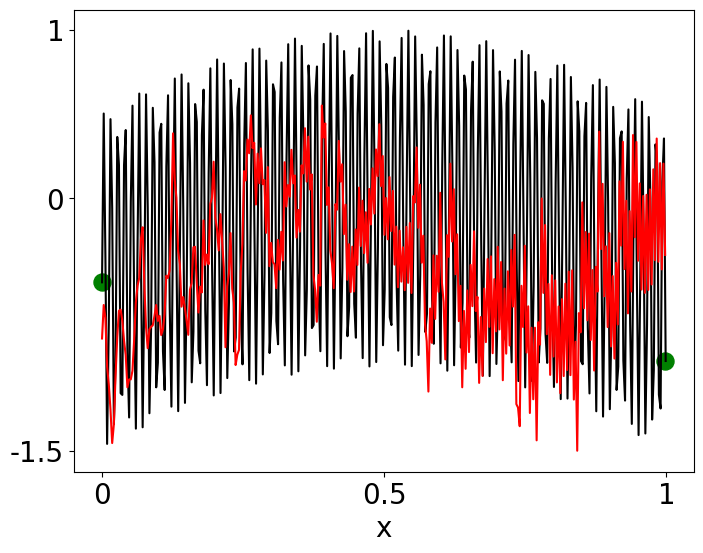

In [33]:
# for poisson_1d-x2_add_sinx
u = lambda x: jnp.sin(500 * x) - 2 * (x - 0.5)**2
x_scale = 1
key = 'd1poisson_dv36_1_10000'
x_tick_label =[[0,0.5,1],['0','$0.5$','$1$']]
y_ticks_label = [[-1.5,0,1],['-1.5','0','1']]


save_name = '../figs/poisson_1d-x2_add_sinx/RFF_PINN'

draw_RFF_PINN(u,data,key,x_scale,save_name,False, x_tick_label , y_ticks_label,30)

equation is:  poisson_1d-x2_add_sinx
kernel is: SE_1d
equation is:  poisson_1d-x2_add_sinx
kernel is: Matern52_1d
equation is:  poisson_1d-x2_add_sinx
kernel is: Matern52_Cos_1d
using extra GP with kernel: Matern52_1d
equation is:  poisson_1d-x2_add_sinx
kernel is: SE_Cos_1d
using extra GP with kernel: Matern52_1d


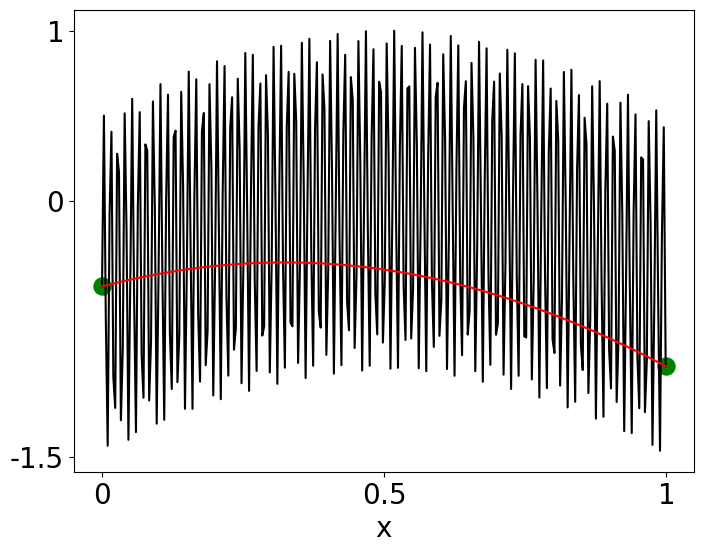

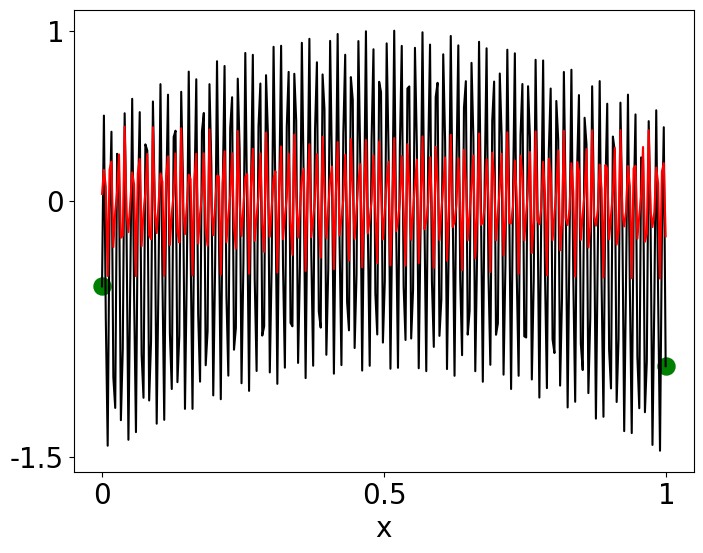

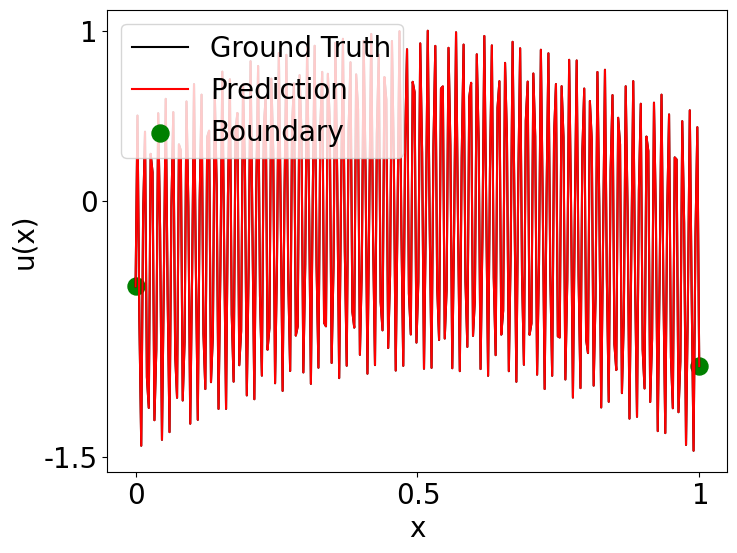

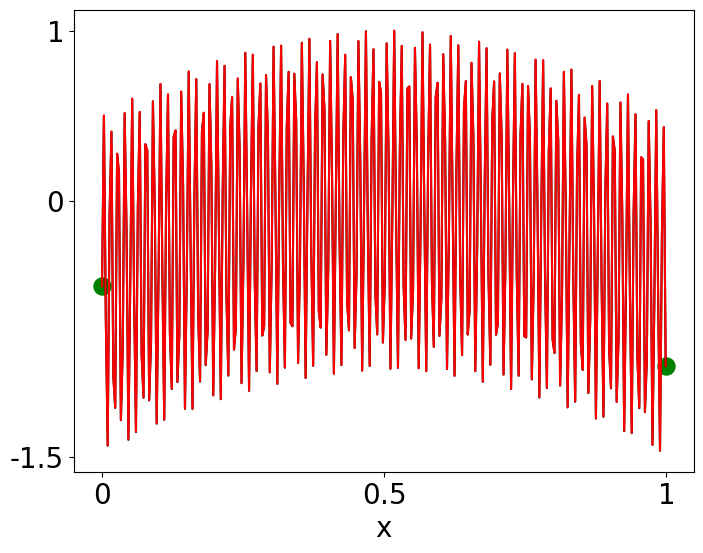

In [34]:
# for poisson_1d-x2_add_sinx
x_tick_label =[[0,0.5,1],['0','$0.5$','$1$']]
y_ticks_label = [[-1.5,0,1],['-1.5','0','1']]


for kernel_name in ['SE_1d','Matern52_1d']:
    prefix = '../result_log/poisson_1d-x2_add_sinx/kernel_%s/epoch_1000000/Q30/'%(kernel_name)
    save_name = 'llk_weight-200.0-nu-1-Q-30-epoch-1000000-lr-0.0100-freqscale=100-logdet-1'

    model, preds, Xtr, log_dict = load_and_predict(prefix, save_name)
    draw_fig(model, preds, Xtr, log_dict,False, x_tick_label, y_ticks_label)


kernel_name = 'Matern52_Cos_1d-extra-Matern52_1d'
prefix = '../result_log/poisson_1d-x2_add_sinx/kernel_%s/epoch_1000000/Q30/'%(kernel_name)
save_name = 'llk_weight-200.0-nu-1-Q-30-epoch-1000000-lr-0.0100-freqscale=100-logdet-1extra_GP_change_point_0.3'
model, preds, Xtr, log_dict = load_and_predict_extra(prefix, save_name)
draw_fig(model, preds, Xtr, log_dict,True,  x_tick_label, y_ticks_label)


kernel_name = 'SE_Cos_1d-extra-Matern52_1d'
prefix = '../result_log/poisson_1d-x2_add_sinx/kernel_%s/epoch_1000000/Q30/'%(kernel_name)
save_name = 'llk_weight-200.0-nu-1-Q-30-epoch-1000000-lr-0.0100-freqscale=100-logdet-1extra_GP_change_point_0.1'
model, preds, Xtr, log_dict = load_and_predict_extra(prefix, save_name)
draw_fig(model, preds, Xtr, log_dict,False, x_tick_label, y_ticks_label)
